Loading Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.datasets import fashion_mnist
from keras.layers import Dense, Flatten, LSTM, Embedding, Dropout, Conv2D, MaxPooling2D

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Loading and Preparing Dataset

In [4]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(test_images.shape)

train_labels = keras.utils.to_categorical(train_labels, 10)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)

test_labels = keras.utils.to_categorical(test_labels, 10)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

4423680/4422102 [==============================] - 0s 0us/step
(10000, 28, 28)


In [ ]:
# Showing Dataset
for i in range(100):
  matplotlib_image = np.array(test_images[i]).reshape(1, 28, 28)
  plt.imshow(matplotlib_image[0])
  plt.show()

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
#class_names = [0, 1,2,3,4,5,6,7,8,9]

In [ ]:
#making the model
moodel = Sequential()
moodel.add(Conv2D(32, kernel_size = (3,3), activation = "relu", input_shape = (28, 28, 1)))
moodel.add(Conv2D(64, (3, 3), activation='relu'))
moodel.add(MaxPooling2D(pool_size = (2,2)))
moodel.add(Dropout(0.25))
moodel.add(Flatten())
moodel.add(Dense(128, activation='relu'))
moodel.add(Dropout(0.5))
moodel.add(Dense(10, activation='softmax'))
moodel.compile(loss = "categorical_crossentropy", optimizer = "adadelta", metrics = ["accuracy"])

moodel.summary()

In [ ]:
#Training the model
print(train_images[0])
print(train_labels[0])
print(type(train_labels))
good_enough = True
while not good_enough:
  moodel.fit(train_images, train_labels, epochs = 20, batch_size = 128, verbose = 1)
  if moodel.evaluate(test_images, test_labels, verbose = 0)[1] > 0.90:
    good_enough = True

In [ ]:
#Evaluate Model
moodel.evaluate(test_images, test_labels, verbose = 0)

[0.3767894506454468, 0.8668000102043152]

In [ ]:
#Get an examples data from dataset
def get_example(test_index):
  test = np.array([test_images[test_index]])
  print(test.shape)
  prediction = list(moodel.predict(test)[0])
  answer = prediction.index(max(prediction))
  res = class_names[answer]
  print(res)
  plt.figure()
  show_image = test_images.reshape(10000, 28, 28)
  plt.imshow(show_image[test_index])
  plt.colorbar()
  plt.grid(False)
  plt.show()
  return res

counter = 0
while get_example(counter) != "Trouser":
  counter += 1

Testing the camera feature:

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.image as mpimg
import io
import cv2
#import imutils
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      console.log(video.width, video.height);
      canvas.width = 550;
      canvas.height = 450;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  image = io.BytesIO(binary)
  i = mpimg.imread(image, format='JPG')
  resized = cv2.resize(i, (28, 28))
  #resized = imutils.resize(i, width =28)
  gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
  plt.imshow(gray, interpolation='nearest')
  plt.show()
  gray = np.array(gray)
  print(gray.shape)
  fixed = []
  for i in gray:
    current = []
    for j in i:
      if j <= 15:
        current.append([5])
      else:
        current.append([j])
    fixed.append(current)
  return fixed

<IPython.core.display.Javascript object>

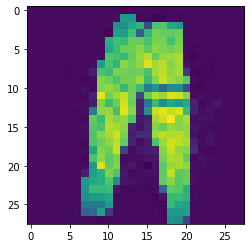

(28, 28)
(1, 28, 28, 1)
[[2.7496559e-03 9.7217780e-01 4.6777682e-04 6.6032219e-03 6.8599416e-04
  4.0511503e-03 1.0339219e-02 2.0392106e-03 3.3851288e-04 5.4745656e-04]]


'Trouser'

In [ ]:
resized = take_photo()
photo = []
#resized = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
#resized = resized[:, :, 0]
photo.append(resized)
photo = np.array(photo)
photo.reshape(1, 28, 28, 1)
print(photo.shape)
p = moodel.predict(photo)
print(p)
results_index = list(p[0]).index(max(list(p[0])))
class_names[results_index]

Testing Model Saving and Loading:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
moodel.save("/content/gdrive/MyDrive/ImageRecognition/model/")

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/ImageRecognition/model/assets


In [ ]:
moodel.save("/content/gdrive/MyDrive/ImageRecognition/h5/my_model.h5")

In [ ]:
from keras.models import load_model
new_model = load_model("/content/gdrive/MyDrive/ImageRecognition/model/")
new_model.summary()
eval = new_model.evaluate(test_images, test_labels, verbose = 1)
print("The model has a loss of {} \nThe model is {}% accurate".format(eval[0], round(eval[1]*100)))